# 4.5. TF-Agents for our Pacman Gym Environment

## Pacman environment exploration

In [94]:
import gym # pip install gym, pip install gym[atari]
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('MsPacman-ram-v0')
_ = env.reset()

In [95]:
print('Observation Spec:')
print(env.observation_space)

print('Reward Spec:')
print(env.reward_range)

print('Action Spec:')
print(env.action_space)

# read more: https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb

Observation Spec:
Box(128,)
Reward Spec:
(-inf, inf)
Action Spec:
Discrete(9)


## TF-Agents

### Environment preprocessing

In [96]:
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent # pip install tf-agents
from tf_agents.networks import q_network
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.policies import random_tf_policy
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [97]:
train_py_env = suite_gym.load('MsPacman-v0')
eval_py_env = suite_gym.load('MsPacman-v0')

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### Agent setup

In [98]:
fc_layer_params = (200,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)


In [99]:
optimizer = tf.compat.v1.train.AdamOptimizer()

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_huber_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [100]:
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=10000)

In [101]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

In [102]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=64, 
    num_steps=2).prefetch(3)

dataset
iterator = iter(dataset)

### Agent training

In [103]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, 10)
returns = [avg_return]

for _ in range(10000):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(100):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % 100 == 0:
        print(f'step = {step}: loss = {train_loss}')

    if step % 1000 == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, 10)
        print(f'step = {step}: Average Return = {avg_return}')
        returns.append(avg_return)

step = 100: loss = 48938.546875
step = 200: loss = 275464.96875
step = 300: loss = 1063324.375
step = 400: loss = 949753.8125
step = 500: loss = 2062866.0
step = 600: loss = 6047792.5


KeyboardInterrupt: 

KeyboardInterrupt: 

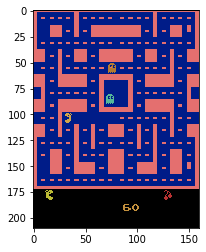

In [70]:
img = plt.imshow(eval_py_env.render(mode='rgb_array')) # only call this once
for _ in range(5):
    time_step = eval_env.reset()
    while not time_step.is_last():
        img.set_data(eval_py_env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)

        action_step = agent.policy.action(time_step)
        time_step = eval_env.step(action_step.action)